In [1]:
from astropy.io import fits
from astropy.nddata import NDData
from astropy.table import Table
from astropy.stats import sigma_clipped_stats
from photutils.psf import extract_stars, EPSFBuilder
import pandas as pd
import numpy as np
from compare_aspect.plots import centile_clip
import matplotlib.pyplot as plt 

In [15]:
photom_table = pd.read_csv(files['old_photom_file'])
    
# filtering for "good" stars 
# could use: 
# sharpness: object sharpness.
# roundness1: object roundness based on symmetry.
# roundness2: object roundness based on marginal Gaussian fits.
# npix: the total number of pixels in the Gaussian kernel array.
# sky: the input sky parameter.
# peak: the peak, sky-subtracted, pixel value of the object.
# flux: the object flux calculated as the peak density in the
# convolved image divided by the detection threshold.

photom_table = photom_table[photom_table['flux'] > 5]
photom_table = photom_table[photom_table['xcentroid'] > 550]
photom_table = photom_table[photom_table['xcentroid'] < 2450]
photom_table = photom_table[photom_table['ycentroid'] > 550]
photom_table = photom_table[photom_table['ycentroid'] < 2450]
photom_table = photom_table[photom_table['sharpness'] > .5]




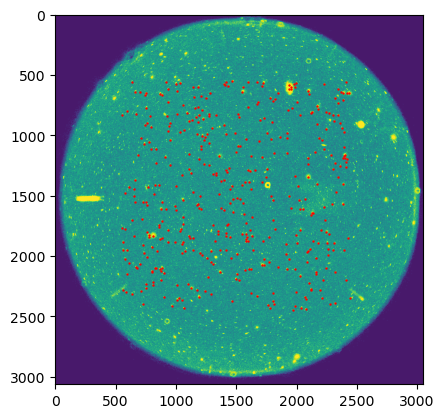

In [16]:
image = fits.open(files['new_image_file'])[1].data


plt.imshow(centile_clip(image))
plt.scatter(photom_table['xcentroid'], photom_table['ycentroid'], s=0.5, c='red')


In [ ]:
image = fits.open(files['old_image_file'])[1].data
plt.imshow(centile_clip(image))

In [17]:
eclipse = 580 
band = "NUV"
leg = 0
local_root = "/home/bekah/gPhoton2/"
og_folder = local_root + "og_asp_"+str(eclipse)
new_folder = local_root + "new_asp"+str(eclipse)
    
def get_good_stars(file_names):
    """get xy list of stars in astropy table, currently using
    gphoton2 main for star detection. """
    photom_table = pd.read_csv(file_names['old_photom_file'])
    
    # filtering for "good" stars 
    photom_table = photom_table[photom_table['flux'] > 5]
    stars_tbl = Table()
    stars_tbl['x'] = photom_table['xcentroid']
    stars_tbl['y'] = photom_table['ycentroid']
    stars_tbl['flux'] = photom_table['flux']
    stars_tbl['dao_max_pix'] = photom_table['peak']
    
    return stars_tbl


def cutout_stars(stars_tbl, imagefile):
    """cutout stars from full-depth image using star table"""
    # open full depth image to clip it (imagefile can be old or new aspect
    # image file path)
    image = fits.open(imagefile)
    data = image[1].data
    # background subtraction
    mean_val, median_val, std_val = sigma_clipped_stats(data, sigma=2.0)
    data -= median_val
    # change nans and inf to 0.0 for nddata purposes for psf fitting
    data = np.nan_to_num(data, copy=True, nan=0.0, posinf=0.0, neginf=0.0)
    # The extract_stars() function requires the input data
    # as an NDData object.
    nddata = NDData(data=data)
    # extract stars, can be done on multiple images
    stars = extract_stars(nddata, stars_tbl, size=21)
    return stars


def make_psf_plots(stars, file):
    """plot 25 of the star cutouts used for the psf fitting"""
    import matplotlib.pyplot as plt
    nrows = 5
    ncols = 5
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5, 5),
                           squeeze=True)
    ax = ax.ravel()
    for i in range(nrows * ncols):
        # currently only plotting the first 25 stars
        ax[i].imshow(centile_clip(stars[i], (0, 99.5)), origin='lower', cmap='viridis')
        ax[i].set_yticklabels([])
        ax[i].set_xticklabels([])
    plt.savefig(file)
    return


def get_file_names(eclipse, band, leg, og_folder, new_folder, root):
    """ image file names and photonlists """
    results = "/home/bekah/test_results/"
    file_names = {}
    eclipse_num = str(eclipse).zfill(5)
    eclipse_str = "e" + eclipse_num
    leg_str = str(leg).zfill(2)
    if band == "NUV":
        b = "nd"
    elif band == "FUV":
        b = "fd"
    og_folder = og_folder + "/" + eclipse_str + "/"
    new_folder = new_folder + "/" + eclipse_str + "/"
    file_names['old_image_file'] = og_folder + eclipse_str + f"-{b}-b{leg_str}-ffull-image-r.fits"
    file_names['new_image_file'] = new_folder + eclipse_str + f"-{b}-b{leg_str}-ffull-image-r.fits"
    # if aperture changes, 12_8 will change. could propagate up as a variable.
    file_names['old_photom_file'] = og_folder + eclipse_str + f"-{b}-b{leg_str}-" \
                                                              f"ffull-image-" \
                                                              f"photom-12_8.csv"
    file_names['old_aspect_parq'] = root+'gPhoton/aspect/aspect.parquet'
    file_names['aspect_parq'] = root+'gPhoton/aspect/aspect2.parquet'

    file_names['psf_comp'] = og_folder + eclipse_str + f"psf_comp.csv"
    file_names['image_comparison'] = og_folder + eclipse_str + "-image-compare.jpg"
    file_names['new_aspect'] = root + "test_data/aspect/" + eclipse_num + "_new_aspect.csv"
    file_names['star_cutouts'] = results + eclipse_str + "-star-cutouts.jpg"
    file_names['star_cutouts_new'] = results + eclipse_str + "-star-cutouts-newasp.jpg"

    return file_names

files = get_file_names(eclipse, band, leg, og_folder, new_folder, local_root) 
